# Example 4 (impulse): MAP estimation   

In [1]:
# To start this notebook with more than one thread run "export JULIA_NUM_THREADS=4" in the terminal 
# before starting the jupyter notebook

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())

4


In [2]:
# Import module. 
using Revise
using PriorNormalization

In [3]:
# Import packages 
using ApproxFun # for approximating gammainvccdf by a Chbychev interpolant to then use AD  
using CairoMakie # for plots 
using FFTW # for discrete cosine transform
using ImagePhantoms # for CT image
using JLD2 # for saving and loading results
using LinearAlgebra # to represent the identity matrix as "I" 
using MIRTjim: jim, prompt # for plotting image
using Optim # for ML and MAP estimation 
using Plots: Plots, plot, plot!, scatter, scatter!, savefig, surface, surface!
using ProgressMeter # to show progress 
using RadonKA # for Radon transform 
using Random # for generating random noise 
using StatsBase # for defining customized distributions 
using StatsFuns # for defining customized distributions 
using StatsPlots # for plotting 
using SparseArrays # for efficient storing of the forward operator 
using SpecialFunctions # for the prior-normalizing transport map

## Define the data model 

In [4]:
# Problem parameters 
n = 20 # number of pixes in each direction 
σ² = 1e-2 # noise variance  
Random.seed!(123) # Setting the random seed 

TaskLocalRNG()

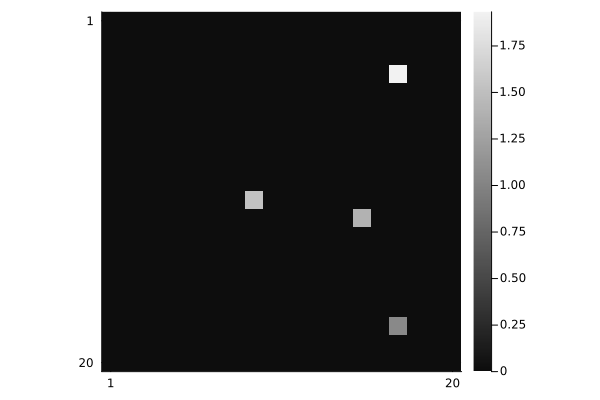

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_imageRef.pdf"

In [5]:
# Fill image with zeros 
image_ref = shepp_logan(n) 
image_ref .= 0

# Fill 5% of the entries with random numbers between 0 and 1 
nr_support = Int64(ceil( (n^2)*1/100 )) 
coord_support = rand(CartesianIndices(image_ref), nr_support)
values_support = rand(Float64, nr_support) .+ 1
image_ref[coord_support] = values_support

p = jim(image_ref)
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "impulse_imageRef.pdf"
)
savefig(output_filename)

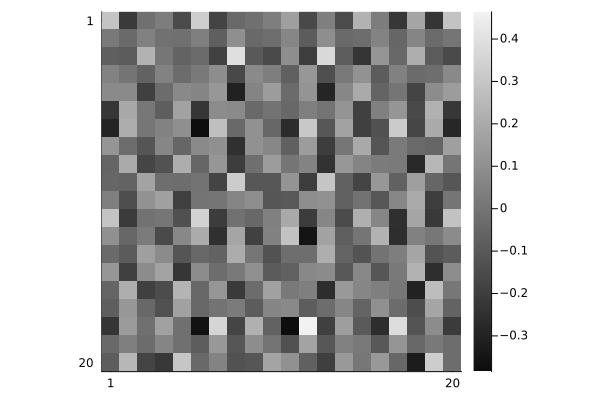

In [6]:
image_dct = FFTW.dct(image_ref)

p = jim(image_dct)
display(p)

# Save the plot 
#script_directory = @__DIR__  # Gets the directory of the current script
#output_filename = joinpath(
#    script_directory, 
#    "figures", 
#    "impulse_imageRadon.pdf"
#)
#savefig(output_filename)

## Forward operator

In [7]:
function forward_operator( x )
    n = Int64(sqrt(length(x)))
    X = reshape(x, n, n) 
    Y = FFTW.dct(X)
    Z = Y
    #Z = Y[1:2:end,1:2:end]
    z = Z[:]
    
    return z
end

forward_operator (generic function with 1 method)

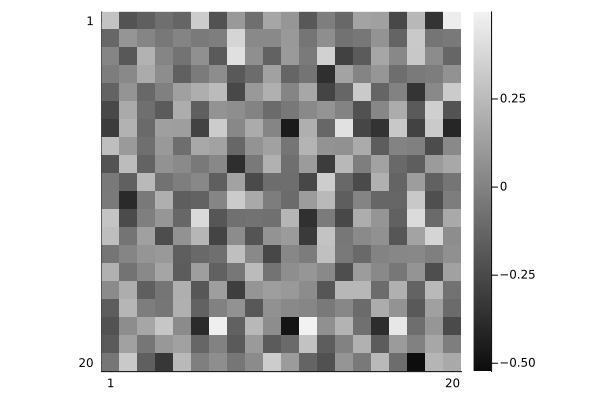

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_obsData.pdf"

In [8]:
y = forward_operator( image_ref[:] ) 
obsData = y + sqrt(σ²).*randn(length(y))
m = Int64(sqrt(length(y)))
    
image_obs = reshape(obsData, m, m)
p = jim(image_obs)
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "impulse_obsData.pdf"
)
savefig(output_filename)

In [9]:
N = n^2
M = length(obsData) 

# Change coordinates to promote sparsity in v = L*u 
forwardOp( x ) = (1/sqrt(σ²)) * forward_operator( x ) 

# Whitening of observational data 
b = (1/sqrt(σ²)) * obsData

400-element Vector{Float64}:
  2.8852735379930277
 -2.108699278108916
 -1.5963443194534173
 -0.8540673827854705
 -1.2900155593819145
  3.266698978321711
 -2.138843660950711
  0.9841282012974863
 -0.8549001347087997
  1.5905261637904005
  0.8720025219925989
 -1.8681149239634625
 -0.19795650346461835
  ⋮
  0.396298123887196
  3.2799753372711518
  1.108234809123376
 -1.3759791180040715
 -2.207967368004505
  0.8102391923102975
 -0.44154620467144856
  2.4052287904527536
 -0.9537772708532144
 -5.237515720165899
  2.233774878528354
  1.6972879497189344

## Generic models for the original and prior-normalized problem

In [10]:
# Different parameters of  generalized gamma hyper-prior 
r_range = [ 1.0, .5, -.5, -1.0 ]; 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ];
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ];

In [11]:
# Define the log-posterior density 
function logpdf_original(θ, z; forwardOp, b, r, β, ϑ)    
    if any(θ .<= 0) # any non-positive element? 
        logpdf = -Inf 
    else
        logpdf = -0.5*norm( forwardOp(z) - b )^2 - 
            0.5*sum( z.^2 ./ θ ) - 
            sum( (θ/ϑ).^r ) + 
            (r*β-1.5)*sum( log.(θ) )
    end
    
    return logpdf
end

logpdf_original (generic function with 1 method)

In [12]:
# Define the posterior density 
function logpdf_priorNormalized(τ, u; forwardOp, b, r, β, ϑ, Φ::Function) 
    
    # Get value of log-prior
    log_prior = -0.5*sum( u.^2 + τ.^2 )
    
    # Get z-value by using transport MAP 
    nr_params = length(u)
    z = zeros(nr_params)
    for i in 1:nr_params
        z[i] = priorNormalizing_KR_inv_tu( u[i], τ[i]; r, β, ϑ, Φ )
    end
    
    # Get the log of the transformed likelihood 
    log_likelihood = -0.5*norm( forwardOp(z) - b )^2

    # Get log-posterior 
    logpdf = log_prior + log_likelihood
    
    return logpdf
end

logpdf_priorNormalized (generic function with 1 method)

## MAP estimation for model with $r=-1$

In [13]:
# Select hyper-hyper-parameters 
model_nr = 4 

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

# We use ApproxFun.jl to build a Chebychev approximation of the function gammainvccdf(β, 1, ⋅) 
interval = Interval(-5, 5)
# Create an array of functions
if r > 0 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5*erfc(τ/sqrt(2)) ), interval)
else 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5 + 0.5*erf(τ/sqrt(2)) ), interval)
end

# Change definition and define negative log-PDF
neg_logpdf_original(ξ) = -logpdf_original(
    ξ[1:2:end-1], ξ[2:2:end]; 
    forwardOp, b, r, β, ϑ
)

# Change definition and define negative log-PDF
neg_logpdf_priorNormalized(ξ) = -logpdf_priorNormalized(
    ξ[1:2:end-1], ξ[2:2:end]; 
    forwardOp, b, r, β, ϑ, Φ=Γinvccdfcheb
)

neg_logpdf_priorNormalized (generic function with 1 method)

### MAP estimate for the original posterior

In [14]:
# Initial guess for the optimization (θ and z)
initial_guess = repeat([1e-3; 0.0], N, 1)

# MAP estimation  
MAP_original = optimize(
    neg_logpdf_original, initial_guess, LBFGS(), 
    Optim.Options(iterations = 1_000, time_limit = 600.0, 
    show_trace = true, show_every = 1)
)

Iter     Function value   Gradient norm 
     0    -6.195672e+03     2.378646e+03
 * time: 0.04822087287902832
     1    -8.139156e+03     1.227761e+04
 * time: 15.81072998046875
     2    -8.210466e+03     1.009151e+04
 * time: 25.46717095375061
     3    -8.248654e+03     5.550726e+03
 * time: 36.39215803146362
     4    -8.257037e+03     1.893641e+03
 * time: 43.76862907409668
     5    -8.258155e+03     2.049797e+02
 * time: 51.19818305969238
     6    -8.258167e+03     2.049732e+02
 * time: 61.65369987487793
     7    -8.261417e+03     1.976609e+04
 * time: 90.86642599105835
     8    -8.261741e+03     3.861402e+03
 * time: 102.9628119468689
     9    -8.261778e+03     1.834350e+03
 * time: 112.37218594551086
    10    -8.261799e+03     5.741140e+02
 * time: 121.78059387207031
    11    -8.261800e+03     1.534547e+02
 * time: 128.33142399787903
    12    -8.261799e+03     1.164962e+02
 * time: 138.6090750694275
    13    -8.261800e+03     4.878060e+01
 * time: 148.09977293014526
 

 * Status: failure (exceeded time limit of 600.0)

 * Candidate solution
    Final objective value:     -8.583114e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.53e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.55e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.06e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.24e-04 ≰ 0.0e+00
    |g(x)|                 = 7.68e+03 ≰ 1.0e-08

 * Work counters
    Seconds run:   601  (vs limit 600)
    Iterations:    89
    f(x) calls:    361
    ∇f(x) calls:   361


In [15]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_original)
θ_MAP = MAP_values[1:2:end-1]
x_MAP = MAP_values[2:2:end] 

# Save the vectors to a file
@save "data/impulse_model$(model_nr)_MAP_original.jld2" θ_MAP x_MAP

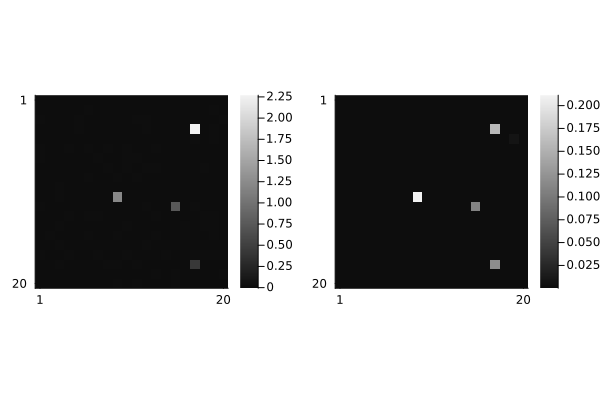

In [16]:
# Get the image values from the increments 
X = reshape(x_MAP, n, n)
p1 = jim(X)

Theta = reshape(θ_MAP, n, n)
p2 = jim(Theta)

p = jim(p1, p2)
display(p)

### MAP estimate for the prior-normalized posterior

In [17]:
# Initial guess for the optimization (τ and v)
initial_guess = repeat([0.0; 0.0], N, 1)

# MAP estimation  
MAP_priorNormalized = optimize(
    neg_logpdf_priorNormalized, initial_guess, LBFGS(), 
    Optim.Options(iterations = 1_000, time_limit = 600.0, 
    show_trace = true, show_every = 1)
)

Iter     Function value   Gradient norm 
     0     6.675486e+02     2.749985e+00
 * time: 4.696846008300781e-5
     1     6.559290e+02     4.197801e+00
 * time: 2.5561118125915527
     2     4.364978e+02     3.481787e+01
 * time: 19.0028338432312
     3     4.364854e+02     3.495420e+01
 * time: 22.994244813919067
     4     4.219524e+02     4.352666e+01
 * time: 26.958616018295288
     5     3.695233e+02     1.429698e+02
 * time: 36.21113300323486
     6     3.645133e+02     1.630394e+02
 * time: 44.40284585952759
     7     3.495979e+02     1.593806e+02
 * time: 52.58178496360779
     8     3.326335e+02     6.477948e+01
 * time: 57.44753384590149
     9     3.304667e+02     2.307728e+01
 * time: 60.579999923706055
    10     3.288445e+02     3.826900e+01
 * time: 66.97499394416809
    11     3.065013e+02     1.302421e+02
 * time: 80.77339100837708
    12     3.058957e+02     1.422543e+02
 * time: 85.24894189834595
    13     2.845263e+02     5.739326e+01
 * time: 89.66433095932007
 

   119     2.196490e+02     5.476173e-06
 * time: 512.0333569049835
   120     2.196490e+02     8.493164e-06
 * time: 517.3304250240326
   121     2.196490e+02     1.546951e-06
 * time: 520.0008058547974
   122     2.196490e+02     2.106317e-06
 * time: 524.0173909664154
   123     2.196490e+02     1.538555e-06
 * time: 528.0123670101166
   124     2.196490e+02     1.261460e-06
 * time: 530.665020942688
   125     2.196490e+02     1.197515e-06
 * time: 533.3464448451996
   126     2.196490e+02     9.824272e-07
 * time: 537.3336248397827
   127     2.196490e+02     3.247672e-06
 * time: 541.3066790103912
   128     2.196490e+02     1.958666e-06
 * time: 545.1583218574524
   129     2.196490e+02     1.300860e-06
 * time: 548.9774439334869
   130     2.196490e+02     2.626989e-06
 * time: 552.8158910274506
   131     2.196490e+02     1.644444e-06
 * time: 556.5356388092041
   132     2.196490e+02     5.752222e-06
 * time: 559.0364038944244
   133     2.196490e+02     3.594381e-06
 * time:

 * Status: failure (objective increased between iterations) (exceeded time limit of 600.0)

 * Candidate solution
    Final objective value:     2.196490e+02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.93e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.99e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.14e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.18e-15 ≰ 0.0e+00
    |g(x)|                 = 4.46e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   601  (vs limit 600)
    Iterations:    143
    f(x) calls:    445
    ∇f(x) calls:   445


In [18]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_priorNormalized)
τ_MAP = MAP_values[1:2:end-1]
u_MAP = MAP_values[2:2:end] 

# Save the vectors to a file
@save "data/impulse_model$(model_nr)_MAP_priorNormalized.jld2" τ_MAP u_MAP

In [19]:
# Compute the pullback of the MAP estimate for (τ,u)

# Initiate the vectors 
θ_pullback = zeros(Float64,N)
x_pullback = zeros(Float64,N)

# Get the pullback values for z and θ
for i in 1:N 
    τ = τ_MAP[i]
    u = u_MAP[i]
    x_pullback[i], θ_pullback[i] = priorNormalizing_KR_inv( u, τ; r, β, ϑ, Φ=Γinvccdfcheb )
end

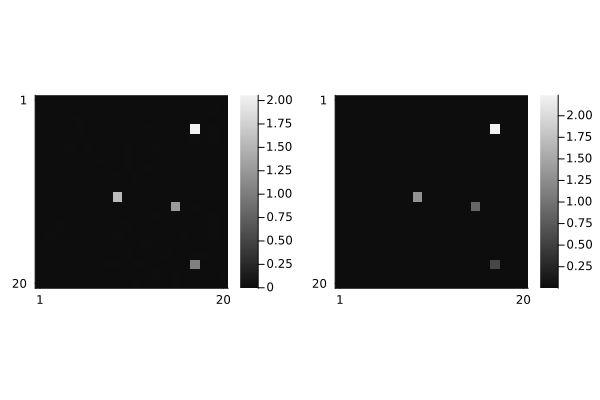

In [20]:
# Get the image values from the increments 
X = reshape(x_pullback, n, n)
p1 = jim(X)

Theta = reshape(θ_pullback, n, n)
p2 = jim(Theta)

p = jim(p1, p2)
display(p)